In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/statlearning/statlearning.py
/kaggle/input/lending-club-loan-data/LCDataDictionary.xlsx
/kaggle/input/lending-club-loan-data/database.sqlite
/kaggle/input/lending-club-loan-data/loan.csv


In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold

In [4]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error
import xgboost as xgb
import lightgbm as lgb

In [5]:
data = pd.read_csv("/kaggle/input/lending-club-loan-data/loan.csv")
data.drop(["id", "member_id", "url"], axis = 1, inplace = True)
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=True)[:20]
missing_data = pd.DataFrame({'Missing Ratio' :round(data_na,4)})
missing_data

,Missing Ratio
zip_code,0.0000
annual_inc,0.0002
total_acc,0.0013
delinq_amnt,0.0013
pub_rec,0.0013
open_acc,0.0013
acc_now_delinq,0.0013
delinq_2yrs,0.0013
earliest_cr_line,0.0013
inq_last_6mths,0.0013


In [7]:
data.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.258957e+06,2.260639e+06,2.260638e+06,1.102166e+06,...,10613.0,10613.000000,10613.0,10613.000000,8426.000000,10613.000000,10613.000000,33056.000000,33056.000000,33056.000000
mean,1.504693e+04,1.504166e+04,1.502344e+04,1.309291e+01,4.458076e+02,7.799243e+04,1.882420e+01,3.068792e-01,5.768354e-01,3.454092e+01,...,3.0,155.006696,3.0,13.686422,454.840802,11628.036442,193.606331,5030.606922,47.775600,13.148596
std,9.190245e+03,9.188413e+03,9.192332e+03,4.832114e+00,2.671737e+02,1.126962e+05,1.418333e+01,8.672303e-01,8.859632e-01,2.190047e+01,...,0.0,129.113137,0.0,9.728138,375.830737,7615.161123,198.694368,3692.027842,7.336379,8.192319
min,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.0,0.640000,3.0,0.000000,1.920000,55.730000,0.010000,44.210000,0.200000,0.000000
25%,8.000000e+03,8.000000e+03,8.000000e+03,9.490000e+00,2.516500e+02,4.600000e+04,1.189000e+01,0.000000e+00,0.000000e+00,1.600000e+01,...,3.0,59.370000,3.0,5.000000,174.967500,5628.730000,43.780000,2227.000000,45.000000,6.000000
50%,1.290000e+04,1.287500e+04,1.280000e+04,1.262000e+01,3.779900e+02,6.500000e+04,1.784000e+01,0.000000e+00,0.000000e+00,3.100000e+01,...,3.0,119.040000,3.0,15.000000,352.605000,10044.220000,132.890000,4172.855000,45.000000,14.000000
75%,2.000000e+04,2.000000e+04,2.000000e+04,1.599000e+01,5.933200e+02,9.300000e+04,2.449000e+01,0.000000e+00,1.000000e+00,5.000000e+01,...,3.0,213.260000,3.0,22.000000,622.792500,16114.940000,284.180000,6870.782500,50.000000,18.000000
max,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,1.719830e+03,1.100000e+08,9.990000e+02,5.800000e+01,3.300000e+01,2.260000e+02,...,3.0,943.940000,3.0,37.000000,2680.890000,40306.410000,1407.860000,33601.000000,521.350000,181.000000


In [8]:
data["loan_status"].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

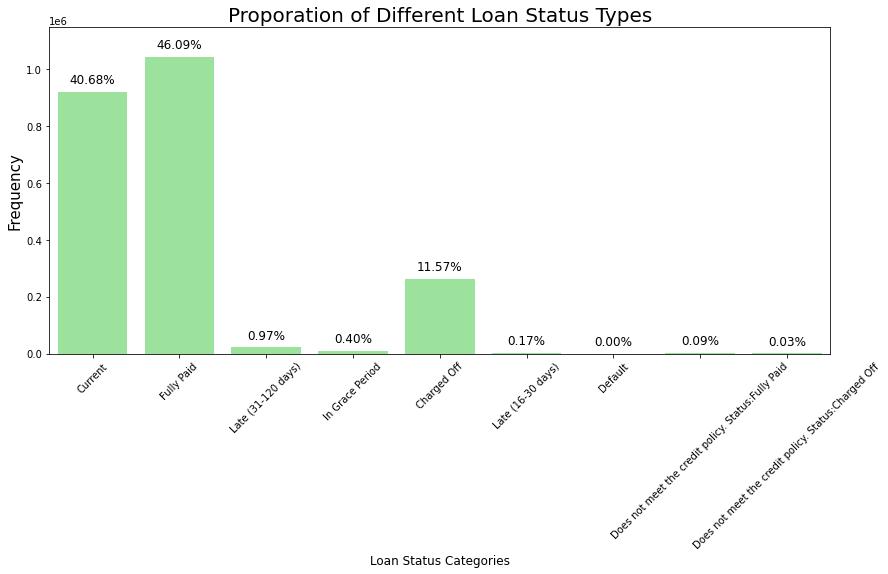

In [9]:
total = len(data)

plt.figure(figsize = (14,6))

g = sns.countplot(x="loan_status", data = data, 
                  color='lightgreen')
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("Loan Status Categories", fontsize=12)
g.set_ylabel("Frequency", fontsize=15)
g.set_title("Proporation of Different Loan Status Types", fontsize = 20)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 30000,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.10)

plt.show()

In [10]:
default = ["Default", "Does not meet the credit policy. Status:Charged Off", "Late (31-120 days)","Charged Off"]
data["Default"] = np.where((data.loan_status  == "Default") | (data.loan_status  == "Does not meet the credit policy. Status:Charged Off") | (data.loan_status  == "Late (31-120 days)") | (data.loan_status  == "Charged Off"), 1, 0)

In [11]:
data["Default"].mean(), 1-data["Default"].mean()

(0.1257787521210545, 0.8742212478789455)

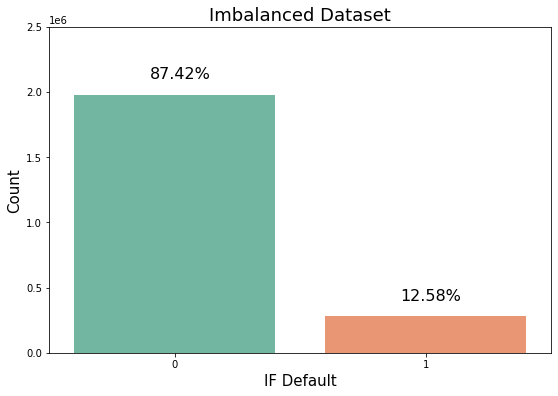

In [12]:
fig = plt.figure()
fig.set_size_inches(9,6)
sns.countplot(x = "Default", data=data, palette="Set2")
plt.title('Imbalanced Dataset', fontsize=18)
plt.text(0.9,400000,"12.58%", fontsize=16)
plt.text(-0.1,2100000,"87.42%", fontsize=16)
plt.ylim(0, 2500000)
plt.xlabel("IF Default", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

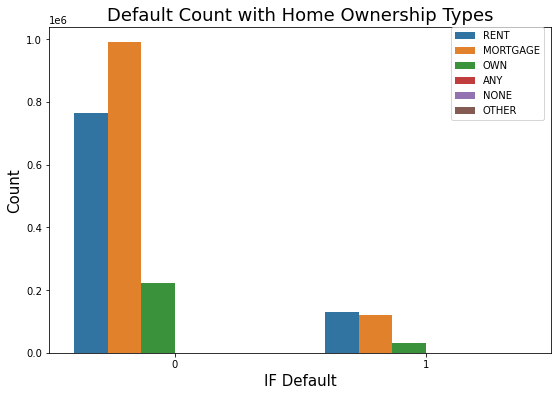

In [13]:
fig = plt.figure()
fig.set_size_inches(9,6)
sns.countplot(x = 'Default', hue = "home_ownership", data=data)
plt.title('Default Count with Home Ownership Types', fontsize=18)
plt.xlabel("IF Default", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.legend(bbox_to_anchor=(0.8, 1), loc=2, borderaxespad=0.)
plt.show()

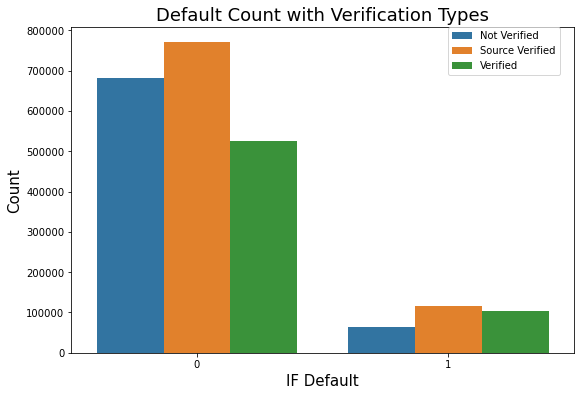

In [14]:
fig = plt.figure()
fig.set_size_inches(9,6)
sns.countplot(x = 'Default', hue = "verification_status", data=data)
plt.title('Default Count with Verification Types', fontsize=18)
plt.xlabel("IF Default", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.legend(bbox_to_anchor=(0.75, 1), loc=2, borderaxespad=0.)
plt.show()

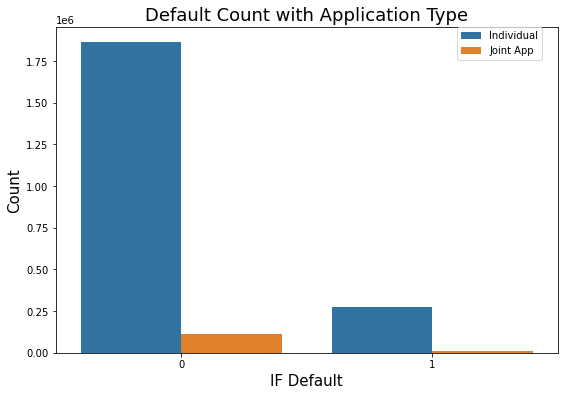

In [15]:
fig = plt.figure()
fig.set_size_inches(9,6)
sns.countplot(x = 'Default', hue = "application_type", data=data)
plt.title('Default Count with Application Type', fontsize=18)
plt.xlabel("IF Default", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.legend(bbox_to_anchor=(0.8, 1), loc=2, borderaxespad=0.)
plt.show()

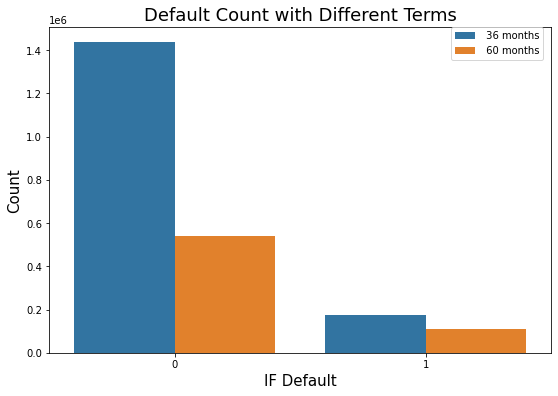

In [16]:
fig = plt.figure()
fig.set_size_inches(9,6)
sns.countplot(x = 'Default', hue = "term", data=data)
plt.title('Default Count with Different Terms', fontsize=18)
plt.xlabel("IF Default", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.legend(bbox_to_anchor=(0.8, 1), loc=2, borderaxespad=0.)
plt.show()

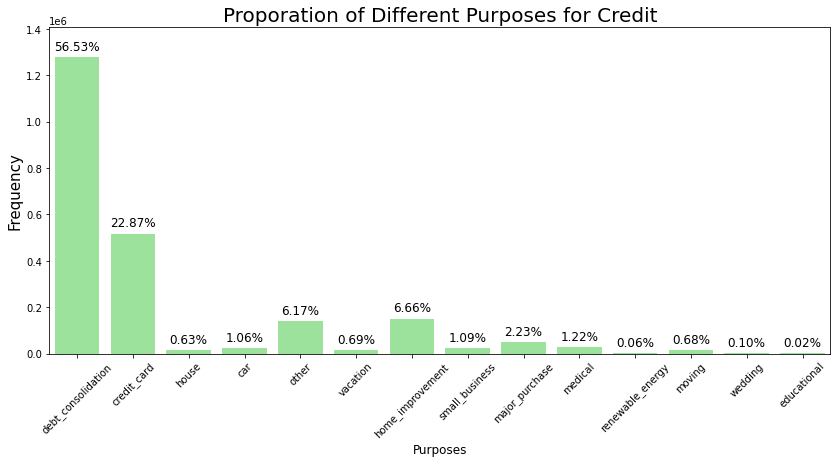

In [17]:
total = len(data)

plt.figure(figsize = (14,6))

g = sns.countplot(x="purpose", data = data, 
                  color='lightgreen')
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("Purposes", fontsize=12)
g.set_ylabel("Frequency", fontsize=15)
g.set_title("Proporation of Different Purposes for Credit", fontsize = 20)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 30000,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.10)

plt.show()

In [18]:
purp_loan= ['purpose', 'Default']
cm = sns.light_palette("green", as_cmap=True)
(round(pd.crosstab(data[purp_loan[0]], data[purp_loan[1]], 
                   normalize='columns') * 100,2)).style.background_gradient(cmap = cm)

Default,0,1
purpose,,
car,1.100000,0.810000
credit_card,23.490000,18.570000
debt_consolidation,55.860000,61.190000
educational,0.020000,0.030000
home_improvement,6.770000,5.840000
house,0.630000,0.610000
major_purchase,2.250000,2.080000
medical,1.210000,1.280000
moving,0.660000,0.830000


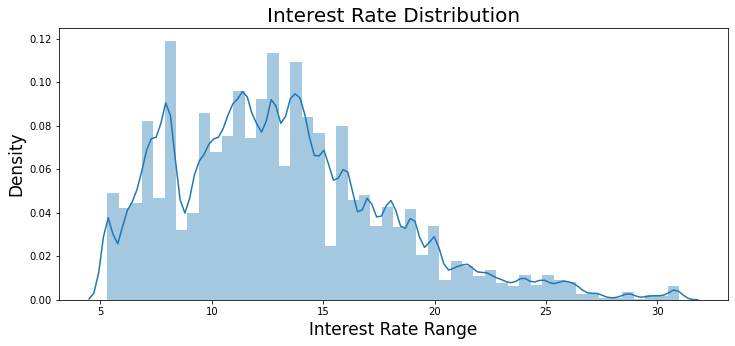

In [19]:
plt.figure(figsize=(12,5))

sns.distplot(data['int_rate'])
plt.title("Interest Rate Distribution", fontsize=20)
plt.xlabel("Interest Rate Range", fontsize=17)
plt.ylabel("Density", fontsize=17)

plt.show()

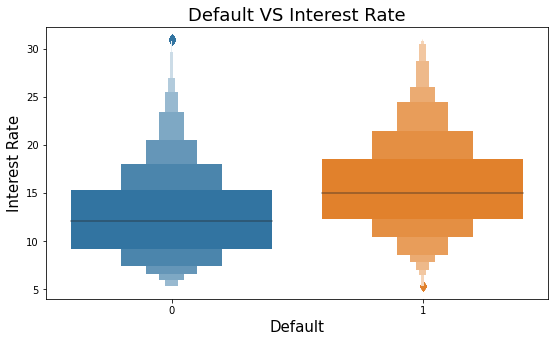

In [20]:
fig = plt.figure()
fig.set_size_inches(9,5)
ax0 = sns.lvplot(x = "Default", y = "int_rate", data=data)
ax0.set_title("Default VS Interest Rate", fontsize = 18)
ax0.set_xlabel("Default", fontsize=15)
ax0.set_ylabel("Interest Rate", fontsize=15)
plt.show()

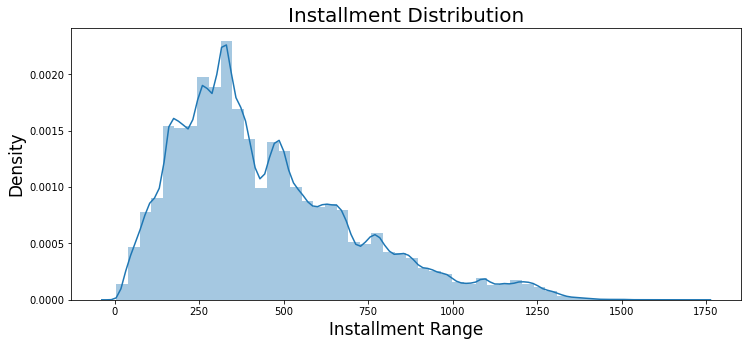

In [21]:
plt.figure(figsize=(12,5))

sns.distplot(data['installment'])
plt.title("Installment Distribution", fontsize=20)
plt.xlabel("Installment Range", fontsize=17)
plt.ylabel("Density", fontsize=17)

plt.show()

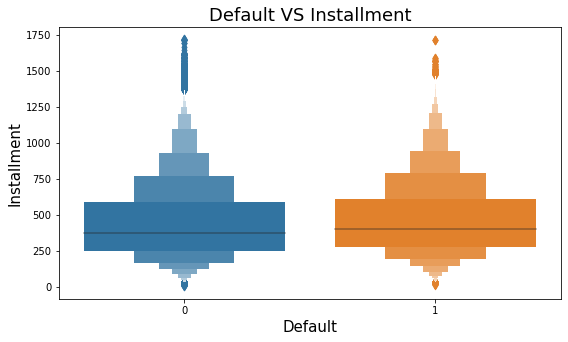

In [22]:
fig = plt.figure()
fig.set_size_inches(9,5)
ax1 = sns.lvplot(x = "Default", y = "installment", data=data)
ax1.set_title("Default VS Installment", fontsize = 18)
ax1.set_xlabel("Default", fontsize=15)
ax1.set_ylabel("Installment", fontsize=15)
plt.show()

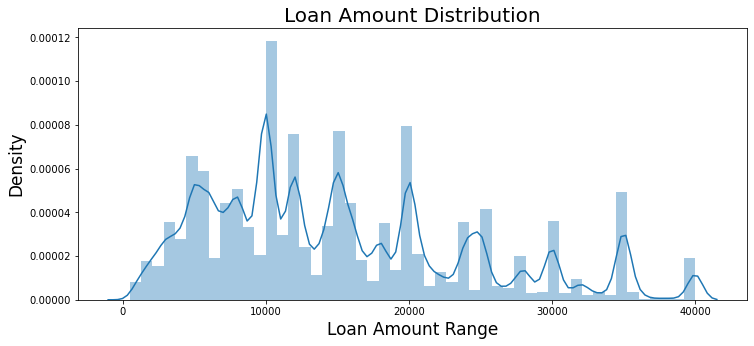

In [23]:
plt.figure(figsize=(12,5))

sns.distplot(data['loan_amnt'])
plt.title("Loan Amount Distribution", fontsize=20)
plt.xlabel("Loan Amount Range", fontsize=17)
plt.ylabel("Density", fontsize=17)

plt.show()

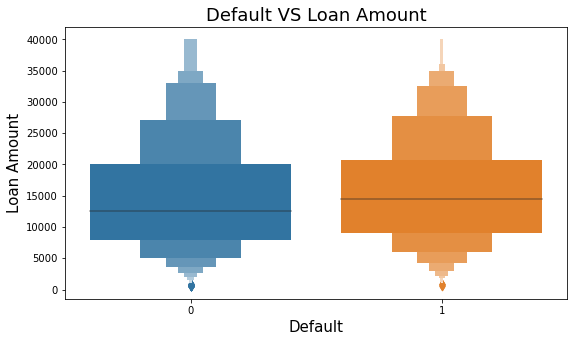

In [24]:
fig = plt.figure()
fig.set_size_inches(9,5)
ax3 = sns.lvplot(x = "Default", y = "loan_amnt", data = data)
ax3.set_title("Default VS Loan Amount", fontsize = 18)
ax3.set_xlabel("Default", fontsize = 15)
ax3.set_ylabel("Loan Amount", fontsize=15)
plt.show()

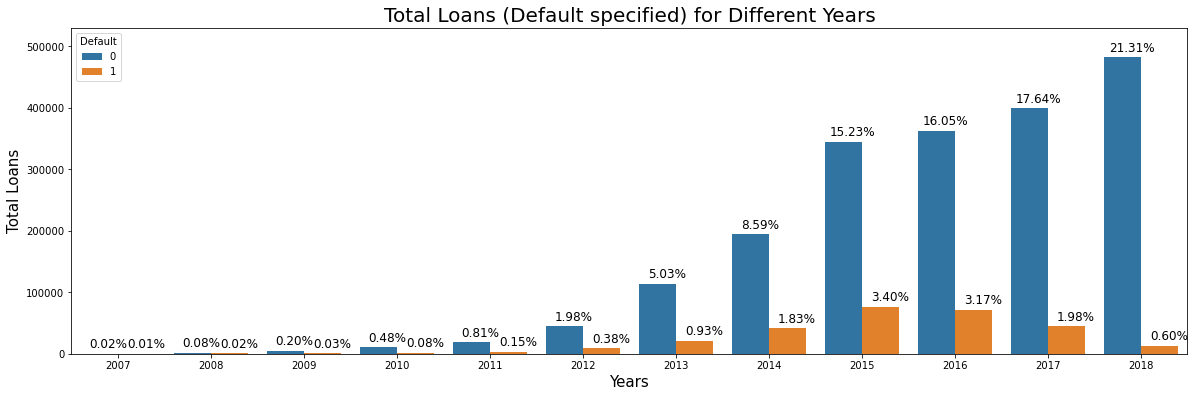

In [25]:
data['issue_month'], data['issue_year'] = data['issue_d'].str.split('-', 1).str
months_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

data['issue_month'] = pd.Categorical(data['issue_month'],
                                        categories = months_order, 
                                        ordered=True)
#Issue_d x loan_amount
plt.figure(figsize = (20,6))

# plt.subplot(311)
# ax = sns.countplot(x = 'issue_month', hue = 'issue_year', 
#                   data = data[data['issue_year'].astype(int) >= 2012])
# #g.set_xticklabels(g.get_xticklabels(),rotation=90)
# ax.set_xlabel("Months of Year", fontsize=15)
# ax.set_ylabel("Count Loans", fontsize=15)
# ax.legend(loc = 'best')
# ax.set_title("Loan Amount by Months", fontsize = 20)

# plt.subplot(312)
#Looking the count of defaults though the issue_d that is The month which the loan was funded
ax1 = sns.countplot(x = 'issue_year', hue = 'Default', 
                   data = data)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 0)
ax1.set_xlabel("Years", fontsize=15)
ax1.set_ylabel("Total Loans", fontsize=15)
ax1.set_title("Total Loans (Default specified) for Different Years", fontsize=20)
sizes=[]
for p in ax1.patches:
    height = p.get_height()
    sizes.append(height)
    ax1.text(p.get_x()+p.get_width()/2.+0.1,
            height + 10000,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize = 12) 
ax1.set_ylim(0, max(sizes) * 1.10)
plt.show()

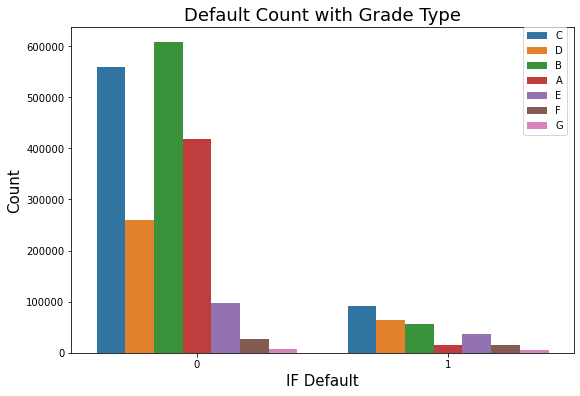

In [26]:
fig = plt.figure()
fig.set_size_inches(9,6)
sns.countplot(x = 'Default', hue = "grade", data=data)
plt.title('Default Count with Grade Type', fontsize=18)
plt.xlabel("IF Default", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.legend(bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0.)
plt.show()

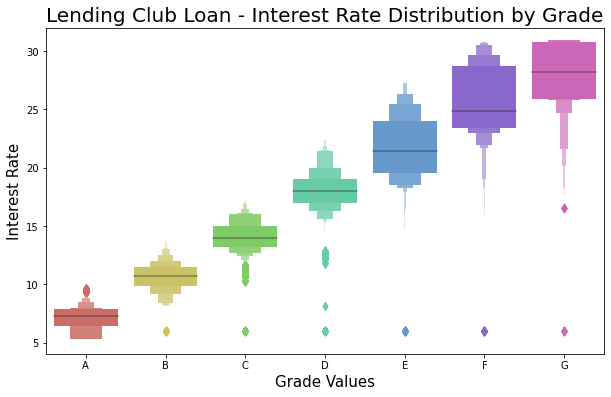

In [27]:
fig = plt.figure()
fig.set_size_inches(10,6)
order_sub = data.groupby("grade")['int_rate'].count().index
g0 = sns.boxenplot(x="grade", y="int_rate", data=data, 
                   palette="hls", order=order_sub)
g0.set_xlabel("Grade Values", fontsize=15)
g0.set_ylabel("Interest Rate", fontsize=15)
g0.set_title("Lending Club Loan - Interest Rate Distribution by Grade", fontsize=20)
plt.show()

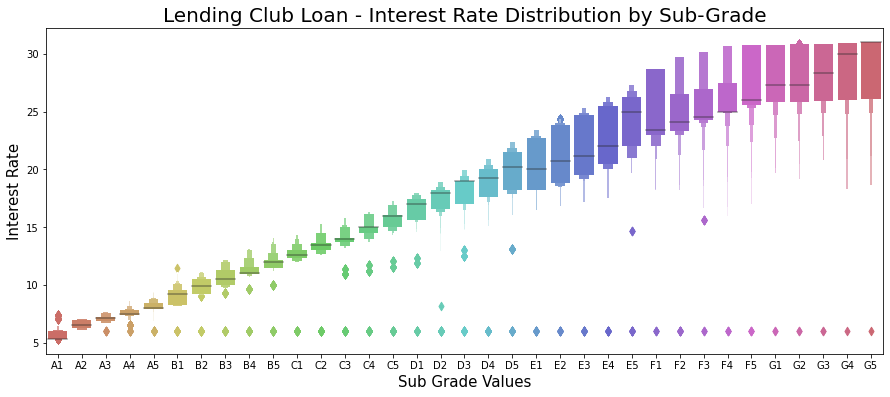

In [28]:
fig = plt.figure()
fig.set_size_inches(15,6)
order_sub = data.groupby("sub_grade")['int_rate'].count().index
g1 = sns.boxenplot(x="sub_grade", y="int_rate", data=data, 
                   palette="hls", order=order_sub)
g1.set_xlabel("Sub Grade Values", fontsize=15)
g1.set_ylabel("Interest Rate", fontsize=15)
g1.set_title("Lending Club Loan - Interest Rate Distribution by Sub-Grade", fontsize=20)
plt.show()

In [29]:
title_mask = data.emp_title.value_counts()[:20].index.values 
cm = sns.light_palette("green", as_cmap=True)

round(pd.crosstab(data[data['emp_title'].isin(title_mask)]['emp_title'], 
                  data[data['emp_title'].isin(title_mask)]['grade'], 
                  normalize='index') * 100,2).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
emp_title,,,,,,,
Accountant,20.320000,31.080000,28.040000,13.150000,5.340000,1.480000,0.590000
Director,25.340000,30.180000,26.720000,11.370000,4.650000,1.420000,0.320000
Driver,15.370000,29.140000,30.740000,16.490000,5.900000,1.730000,0.620000
Engineer,26.250000,29.380000,25.920000,11.570000,4.850000,1.590000,0.450000
General Manager,19.530000,29.760000,29.180000,13.580000,5.770000,1.690000,0.500000
Manager,19.310000,28.790000,29.440000,14.020000,5.990000,1.810000,0.640000
Office Manager,18.750000,28.780000,29.450000,14.660000,6.200000,1.730000,0.430000
Operations Manager,19.550000,28.790000,29.340000,13.890000,6.170000,1.710000,0.550000
Owner,21.250000,31.150000,27.780000,13.060000,4.860000,1.400000,0.490000


In [30]:
len_mask = data.emp_length.value_counts()[:20].index.values 
cm = sns.light_palette("green", as_cmap=True)

round(pd.crosstab(data[data['emp_length'].isin(len_mask)]['emp_length'], 
                  data[data['emp_length'].isin(len_mask)]['grade'], 
                  normalize='index') * 100,2).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
emp_length,,,,,,,
1 year,18.290000,29.120000,29.380000,14.850000,6.010000,1.790000,0.560000
10+ years,19.810000,29.500000,28.400000,13.960000,5.920000,1.870000,0.540000
2 years,18.770000,29.370000,29.000000,14.450000,6.040000,1.840000,0.540000
3 years,18.820000,29.400000,28.990000,14.360000,6.030000,1.850000,0.540000
4 years,19.000000,29.140000,28.840000,14.600000,6.060000,1.820000,0.530000
5 years,19.070000,29.350000,28.610000,14.540000,6.010000,1.890000,0.540000
6 years,18.870000,29.470000,28.700000,14.410000,6.020000,1.950000,0.580000
7 years,18.600000,29.170000,28.680000,14.740000,6.180000,2.040000,0.590000
8 years,18.830000,29.330000,28.540000,14.210000,6.440000,2.080000,0.560000


RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

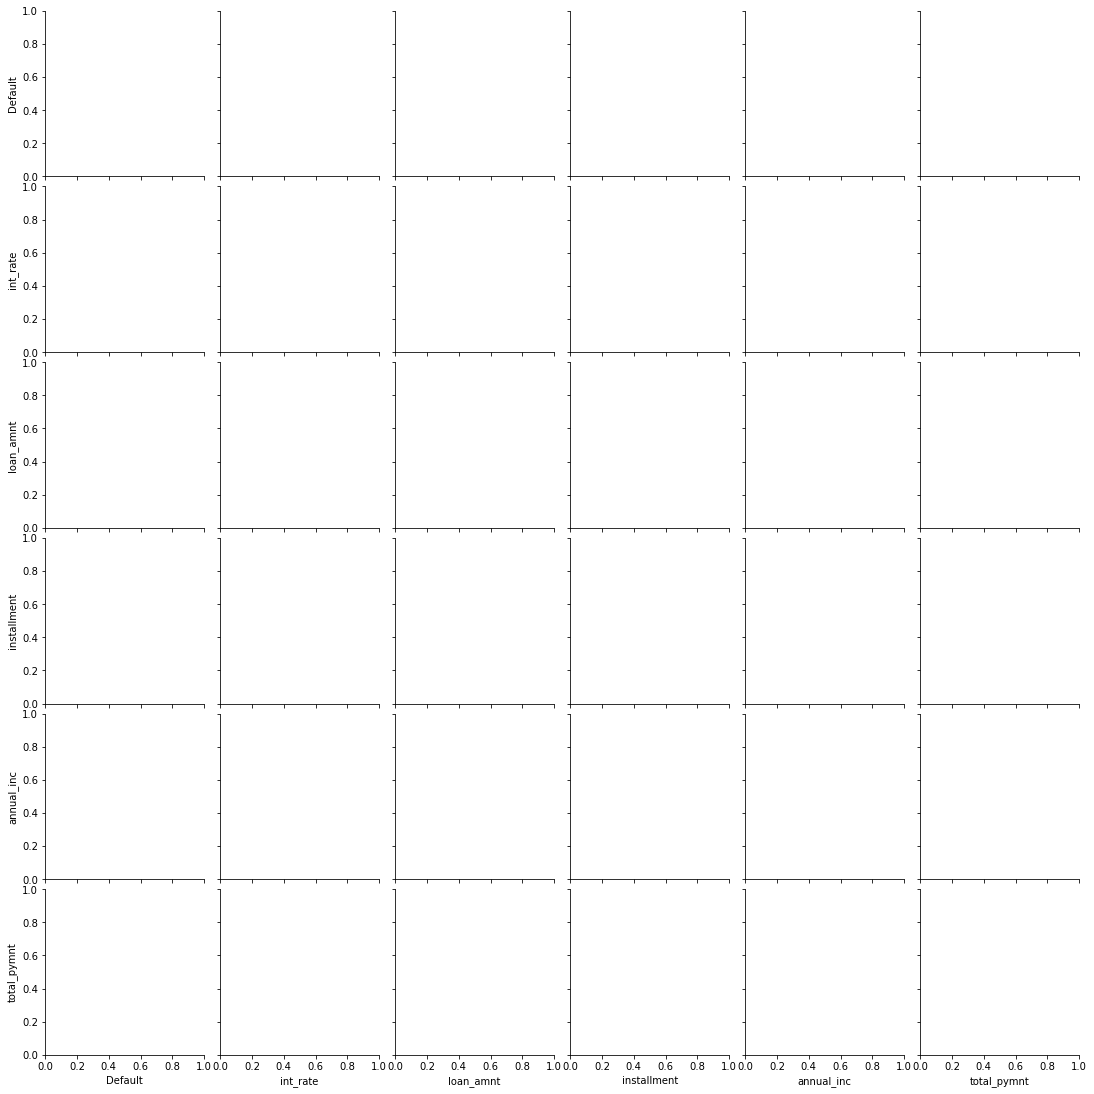

In [32]:
sns.pairplot(data[['Default', 'int_rate', "loan_amnt", "installment", "annual_inc", "total_pymnt"]], hue = "Default")
plt.show()